
Table C.1 Eigenvalues and Explained Variance:
 PC   Eigenvalue   Explained %   Cumulative %
PC1:   13.1383        28.15%        28.15%
PC2:   9.0605        19.42%        47.57%
PC3:   7.6481        16.39%        63.96%
PC4:   5.7713        12.37%        76.32%
PC5:   3.5708        7.65%        83.98%
PC6:   3.2084        6.88%        90.85%
PC7:   1.8629        3.99%        94.84%
PC8:   1.5785        3.38%        98.23%
PC9:   0.8279        1.77%        100.00%
PC10:   0.0000        0.00%        100.00%

Table C.2 Factor Loadings (Top 4 PCs):
                 PC1    PC2    PC3    PC4
ChatGPT4.5-1   0.682 -0.380 -0.229 -0.044
ChatGPT4.5-2   0.476 -0.371 -0.514  0.009
ChatGPT4.5-3   0.890 -0.113  0.075 -0.341
ChatGPT4.5-4   0.547  0.445 -0.164  0.110
ChatGPT4.5-5   0.160 -0.549 -0.411  0.196
ChatGPT4.5-6   0.643  0.200 -0.447  0.128
ChatGPT4.5-7   0.476 -0.332  0.172  0.614
Gemini-2.5-1  -0.424 -0.304  0.374 -0.555
Gemini-2.5-2   0.617  0.248 -0.040  0.645
Gemini-2.5-3  -0.586  0.297  

C:\Users\otsuka\AppData\Local\Temp\ipykernel_12488\2120678541.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Dark2')


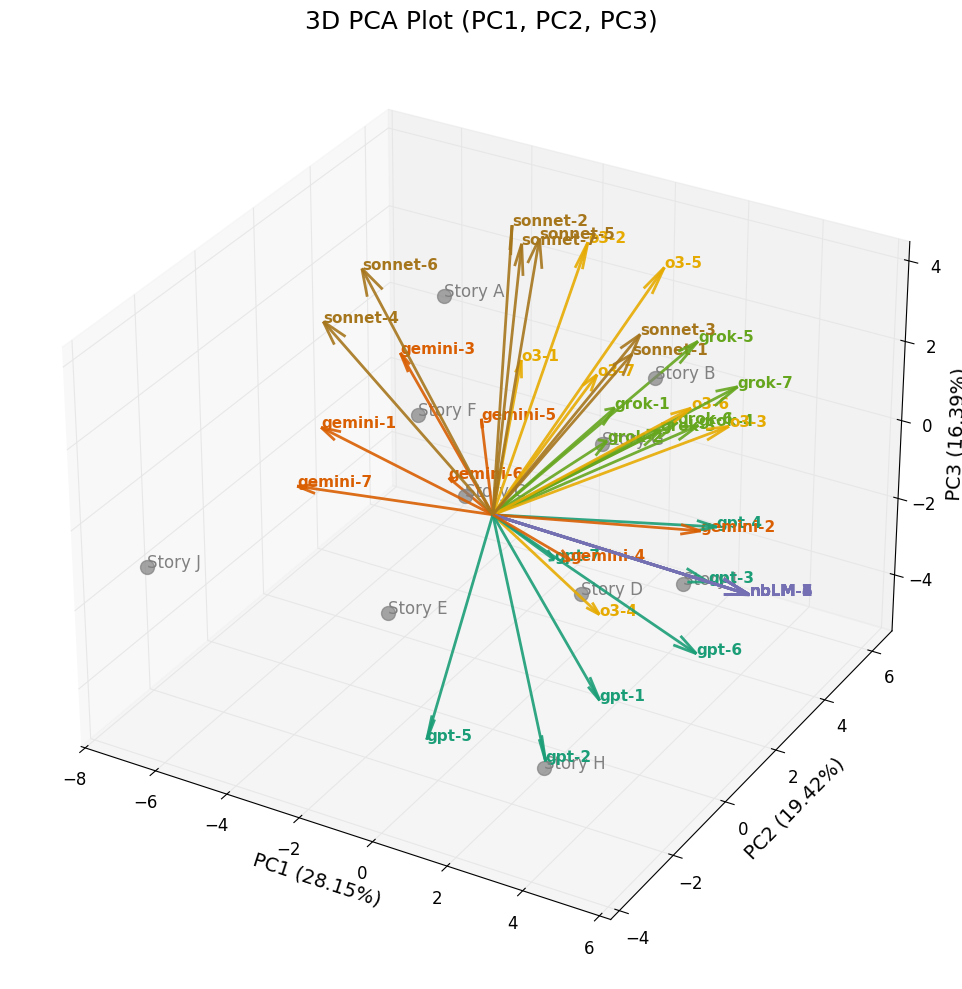

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.mplot3d import Axes3D

# Load CSV data
df = pd.read_csv('official_row_data.csv', encoding='utf-8')

# Pivot to wide format: each column = model-session
df_cross = (
    df
    .set_index(['story', 'model', 'session'])['score']
    .unstack(['model', 'session'])
    .reset_index()
)

df_cross.columns = [
    col if isinstance(col, str) else f"{col[0]}-{col[1]}"
    for col in df_cross.columns
]

# Prepare PCA input
story_titles = df_cross['story-'].values
X = df_cross.drop('story-', axis=1).values
feature_names = df_cross.columns[1:].tolist()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
principal_components = pca.fit_transform(X_scaled)

# Eigenvalues and variance
eigenvalues = pca.explained_variance_
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\nTable C.1 Eigenvalues and Explained Variance:")
print(" PC   Eigenvalue   Explained %   Cumulative %")
for i, (eig, var, cum) in enumerate(zip(eigenvalues, explained_variance, cumulative_variance)):
    print(f"PC{i+1}:   {eig:.4f}        {var*100:.2f}%        {cum*100:.2f}%")

# Factor loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

max_pcs = min(4, len(feature_names))
loadings_df = pd.DataFrame(
    loadings[:, :max_pcs],
    index=feature_names,
    columns=[f'PC{i+1}' for i in range(max_pcs)]
)

print("\nTable C.2 Factor Loadings (Top 4 PCs):")
print(loadings_df.round(3))

# Define color mapping for models
unique_models = df['model'].unique()
cmap = plt.cm.get_cmap('Dark2')
model_color_dict = {
    model: cmap(i / len(unique_models))
    for i, model in enumerate(unique_models)
}

# Abbreviated model names
model_short_names = {}
for model in unique_models:
    if 'GPT' in model:
        model_short_names[model] = 'gpt'
    elif 'Gemini' in model:
        model_short_names[model] = 'gemini'
    elif 'Notebook' in model:
        model_short_names[model] = 'nbLM'
    elif 'Open' in model:
        model_short_names[model] = 'o3'
    elif 'Grok' in model:
        model_short_names[model] = 'grok'
    elif 'Sonnet' in model:
        model_short_names[model] = 'sonnet'
    else:
        model_short_names[model] = model

# Plot 3D PCA (PC1, PC2, PC3)
if len(explained_variance) >= 3:
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot stories
    for i, title in enumerate(story_titles):
        ax.scatter(principal_components[i, 0], principal_components[i, 1], principal_components[i, 2],
                   c='gray', s=100, alpha=0.7)
        ax.text(principal_components[i, 0], principal_components[i, 1], principal_components[i, 2],
                title, fontsize=12, color='gray')

    # Plot loading vectors
    scaling_factor = 7
    for model in unique_models:
        model_features = [f for f in feature_names if f.startswith(model)]
        indices = [feature_names.index(f) for f in model_features]
        for idx in indices:
            x = loadings[idx, 0] * scaling_factor
            y = loadings[idx, 1] * scaling_factor
            z = loadings[idx, 2] * scaling_factor
            ax.quiver(0, 0, 0, x, y, z, color=model_color_dict[model], alpha=0.9,
                      linewidth=2.0, arrow_length_ratio=0.1)
            ses_id = feature_names[idx].split('-')[-1]
            label = f"{model_short_names[model]}-{ses_id}"
            ax.text(x, y, z, label, color=model_color_dict[model], fontsize=11, fontweight='bold')

    # Axes and labels
    ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)', fontsize=14)
    ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)', fontsize=14)
    ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.2f}%)', fontsize=14)
    ax.set_title('3D PCA Plot (PC1, PC2, PC3)', fontsize=18)
    ax.tick_params(axis='both', labelsize=12)

    # Grid color adjustment
    ax.xaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.92)
    ax.yaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.92)
    ax.zaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.92)

    plt.tight_layout()
    print("\nFigure C-1: 3D PCA Space")
    plt.show()
